In [1]:
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    BatchNormalization, Dropout,
    Dense, GlobalAveragePooling2D
)

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


In [2]:
TARGET_SR = 16000
DURATION = 4.0
N_MELS = 128
N_FFT = 2048
HOP = 512


In [7]:
splits = {
    "train": "data/train-00000-of-00001.parquet"
}

df = pd.read_parquet(
    "hf://datasets/mteb/nsynth-mini/" + splits["train"]
)

df = df.reset_index(drop=True)
print(df.shape)


(3001, 14)


In [ ]:
df.head()

,audio,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
0,{'bytes': b'RIFF$\xf4\x01\x00WAVEfmt \x10\x00\...,180871,16000,81,0,mallet,mallet_acoustic_065,mallet_acoustic_065-081-127,"[fast_decay, percussive]",acoustic,127,5,676,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
1,{'bytes': b'RIFF$\xf4\x01\x00WAVEfmt \x10\x00\...,176097,16000,106,1,mallet,mallet_electronic_004,mallet_electronic_004-106-075,"[bright, distortion, nonlinear_env]",electronic,75,5,192,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
2,{'bytes': b'RIFF$\xf4\x01\x00WAVEfmt \x10\x00\...,82568,16000,58,2,flute,flute_synthetic_006,flute_synthetic_006-058-127,[distortion],synthetic,127,2,608,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,{'bytes': b'RIFF$\xf4\x01\x00WAVEfmt \x10\x00\...,231048,16000,77,2,bass,bass_synthetic_131,bass_synthetic_131-077-127,[distortion],synthetic,127,0,909,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,{'bytes': b'RIFF$\xf4\x01\x00WAVEfmt \x10\x00\...,75231,16000,68,0,string,string_acoustic_017,string_acoustic_017-068-025,[reverb],acoustic,25,8,120,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [4]:
def preprocess_audio(audio_bytes):
    audio, sr = sf.read(io.BytesIO(audio_bytes))

    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)

    if sr != TARGET_SR:
        audio = librosa.resample(audio, sr, TARGET_SR)

    audio = audio / (np.max(np.abs(audio)) + 1e-9)

    audio, _ = librosa.effects.trim(audio, top_db=25)


    target_len = int(TARGET_SR * DURATION)
    if len(audio) < target_len:
        audio = np.pad(audio, (0, target_len - len(audio)))
    else:
        audio = audio[:target_len]

    return audio.astype(np.float32)


In [5]:
def extract_features(audio):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=TARGET_SR,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP,
        power=2.0
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    delta = librosa.feature.delta(mel_db)
    delta2 = librosa.feature.delta(mel_db, order=2)

    features = np.stack([mel_db, delta, delta2], axis=-1)
    return features.astype(np.float32)


In [8]:
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    audio = preprocess_audio(row["audio"]["bytes"])
    feat = extract_features(audio)

    X.append(feat)
    y.append(row["instrument_family"])

X = np.array(X)
y = np.array(y)

print(X.shape)


100%|██████████| 3001/3001 [01:13<00:00, 40.96it/s]


(3001, 128, 126, 3)


In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


In [10]:
num_classes = len(np.unique(y))

y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val, num_classes)
y_test  = to_categorical(y_test, num_classes)


In [11]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)

class_weights = dict(enumerate(weights))


In [ ]:
model = Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), padding="same", activation="relu"),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,651 (1.62 MB)

 Trainable params: 423,691 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.3
    )
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 136s 998ms/step - accuracy: 0.1629 - loss: 2.3855 - val_accuracy: 0.1089 - val_loss: 4.0064 - learning_rate: 0.0010
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.2594 - loss: 2.0992 - val_accuracy: 0.3222 - val_loss: 1.7213 - learning_rate: 0.0010
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 130s 985ms/step - accuracy: 0.3232 - loss: 1.8172 - val_accuracy: 0.0556 - val_loss: 3.7138 - learning_rate: 0.0010
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 136s 943ms/step - accuracy: 0.3801 - loss: 1.6928 - val_accuracy: 0.3178 - val_loss: 2.0031 - learning_rate: 0.0010
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 131s 990ms/step - accuracy: 0.4037 - loss: 1.5977 - val_accuracy: 0.3422 - val_loss: 1.7002 - learning_rate: 0.0010
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 998ms/step - accuracy: 0.4316 - loss: 1.4357 - val_accuracy: 0.2178 - val_loss: 3.7542 - learning_rate: 0.0010
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 136s 950ms/step - accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.6166 - loss: 1.0369
Test accuracy: 0.5986696481704712


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_audio_cnn_3ch(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3,3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model


In [14]:
num_classes = y_train.shape[1]

model = build_audio_cnn_3ch(
    input_shape=X_train.shape[1:],
    num_classes=num_classes
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 126, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 63, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,032,331 (3.94 MB)

 Trainable params: 1,030,923 (3.93 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6832 - loss: 0.8587 - val_accuracy: 0.6467 - val_loss: 0.9956 - learning_rate: 2.4300e-06
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7033 - loss: 0.8167 - val_accuracy: 0.6533 - val_loss: 0.9943 - learning_rate: 2.4300e-06
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6829 - loss: 0.8267 - val_accuracy: 0.6556 - val_loss: 0.9925 - learning_rate: 2.4300e-06
Epoch 4/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7074 - loss: 0.8046 - val_accuracy: 0.6556 - val_loss: 0.9910 - learning_rate: 2.4300e-06
Epoch 5/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6857 - loss: 0.8168 - val_accuracy: 0.6556 - val_loss: 0.9902 - learning_rate: 2.4300e-06
Epoch 6/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6915 - loss: 0.8085 - val_accuracy: 0.6556 - val_loss: 0.9890 - learning_rate: 2.4300e-06
Epoch 7/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6799 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.6562 - loss: 0.9797
Test Accuracy: 62.97%


In [ ]:
import numpy as np

y_pred_probs = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step


<Figure size 800x800 with 0 Axes>

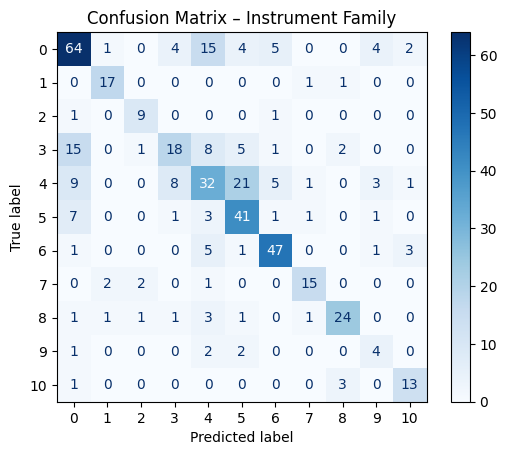

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Instrument Family")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.65      0.64        99
           1       0.81      0.89      0.85        19
           2       0.69      0.82      0.75        11
           3       0.56      0.36      0.44        50
           4       0.46      0.40      0.43        80
           5       0.55      0.75      0.63        55
           6       0.78      0.81      0.80        58
           7       0.79      0.75      0.77        20
           8       0.80      0.73      0.76        33
           9       0.31      0.44      0.36         9
          10       0.68      0.76      0.72        17

    accuracy                           0.63       451
   macro avg       0.64      0.67      0.65       451
weighted avg       0.63      0.63      0.62       451



In [ ]:
import numpy as np

num_classes = y_test.shape[1]

for cls in range(num_classes):
    idx = (y_true == cls)
    acc = np.mean(y_pred[idx] == y_true[idx])
    print(f"Class {cls} Accuracy: {acc:.3f}")


Class 0 Accuracy: 0.646
Class 1 Accuracy: 0.895
Class 2 Accuracy: 0.818
Class 3 Accuracy: 0.360
Class 4 Accuracy: 0.400
Class 5 Accuracy: 0.745
Class 6 Accuracy: 0.810
Class 7 Accuracy: 0.750
Class 8 Accuracy: 0.727
Class 9 Accuracy: 0.444
Class 10 Accuracy: 0.765


In [ ]:
def top_k_accuracy(y_true, y_probs, k=3):
    top_k = np.argsort(y_probs, axis=1)[:, -k:]
    return np.mean([y_true[i] in top_k[i] for i in range(len(y_true))])

print("Top-2 Accuracy:", top_k_accuracy(y_true, y_pred_probs, k=2))
print("Top-3 Accuracy:", top_k_accuracy(y_true, y_pred_probs, k=3))


Top-2 Accuracy: 0.8292682926829268
Top-3 Accuracy: 0.9157427937915743


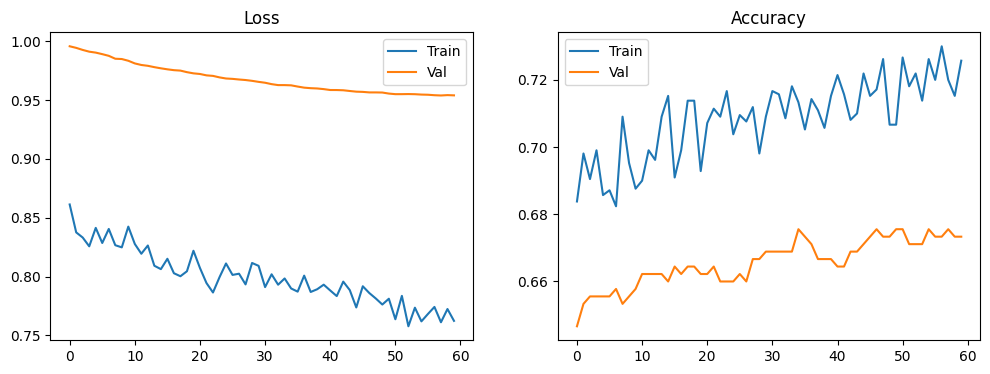

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [17]:
optimizer_sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer_sgd,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [18]:
sgd_lrs = [0.01, 0.005]


In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )
]


In [20]:
history_sgd = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - accuracy: 0.2588 - loss: 2.1044 - val_accuracy: 0.2178 - val_loss: 4.5578 - learning_rate: 0.0100
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.3576 - loss: 1.7818 - val_accuracy: 0.2178 - val_loss: 4.8857 - learning_rate: 0.0100
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - accuracy: 0.3885 - loss: 1.6556 - val_accuracy: 0.2178 - val_loss: 4.1223 - learning_rate: 0.0100
Epoch 4/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.4085 - loss: 1.5790 - val_accuracy: 0.2178 - val_loss: 5.8846 - learning_rate: 0.0100
Epoch 5/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.4346 - loss: 1.5331 - val_accuracy: 0.2289 - val_loss: 4.5786 - learning_rate: 0.0100
Epoch 6/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.4611 - loss: 1.4916 - val_accuracy: 0.1311 - val_loss: 5.2274 - learning_rate: 0.0100
Epoch 7/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.4671 - loss: 1.4168 - val_acc

In [21]:
import numpy as np

y_prob = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


In [27]:
test_loss, test_accuracy = model.evaluate(
    X_test,
    y_test,
    batch_size=32,
    verbose=1
)

print(f"Test Accuracy (SGD): {test_accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7100 - loss: 0.9228
Test Accuracy (SGD): 67.18%


In [22]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_true, y_pred, average="macro")
micro_f1 = f1_score(y_true, y_pred, average="micro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Macro F1    : {macro_f1:.4f}")
print(f"Micro F1    : {micro_f1:.4f}")
print(f"Weighted F1 : {weighted_f1:.4f}")


Macro F1    : 0.6471
Micro F1    : 0.6718
Weighted F1 : 0.6723


In [23]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    digits=4
))


              precision    recall  f1-score   support

           0     0.7064    0.7778    0.7404        99
           1     0.8500    0.8947    0.8718        19
           2     0.8000    0.7273    0.7619        11
           3     0.5077    0.6600    0.5739        50
           4     0.5513    0.5375    0.5443        80
           5     0.6078    0.5636    0.5849        55
           6     0.9556    0.7414    0.8350        58
           7     0.7647    0.6500    0.7027        20
           8     0.8065    0.7576    0.7812        33
           9     0.0000    0.0000    0.0000         9
          10     0.6842    0.7647    0.7222        17

    accuracy                         0.6718       451
   macro avg     0.6577    0.6431    0.6471       451
weighted avg     0.6802    0.6718    0.6723       451



In [24]:
import numpy as np

num_classes = y_test.shape[1]

for cls in range(num_classes):
    idx = (y_true == cls)
    cls_acc = np.mean(y_pred[idx] == y_true[idx])
    print(f"Class {cls} Accuracy: {cls_acc:.3f}")


Class 0 Accuracy: 0.778
Class 1 Accuracy: 0.895
Class 2 Accuracy: 0.727
Class 3 Accuracy: 0.660
Class 4 Accuracy: 0.537
Class 5 Accuracy: 0.564
Class 6 Accuracy: 0.741
Class 7 Accuracy: 0.650
Class 8 Accuracy: 0.758
Class 9 Accuracy: 0.000
Class 10 Accuracy: 0.765


<Figure size 800x800 with 0 Axes>

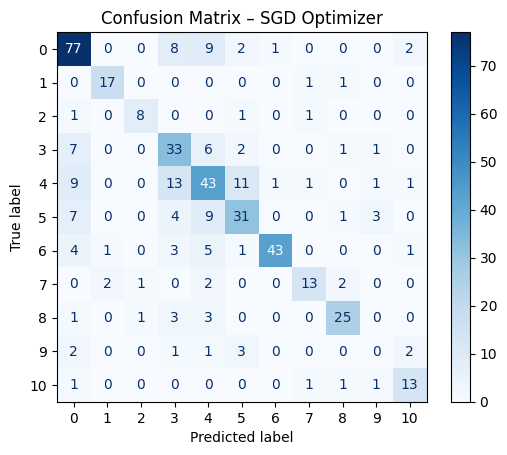

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – SGD Optimizer")
plt.show()
